In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# read in the words
words = open("names.txt", 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
# build the vocab of the words
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [5]:
# build the dataset

block_size = 3

def build_dataset(words):
    X, Y = [], []

    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)

n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


$$ \text{std} = \frac{\text{gain}}{\sqrt{\text{fan\_in}}} $$

In [7]:
# mlp revisit

n_embed = 10 # dimensionality of the embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) 
C = torch.randn((vocab_size, n_embed), generator=g)
W1 = torch.randn((n_embed * block_size, n_hidden), generator=g) * ((5/3) / (n_embed * block_size)**0.5)  # * 0.2 #hidden layer 
#b1 = torch.randn(n_hidden, generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0

bngain = torch.ones((1, n_hidden))
bnbias = torch.ones((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.zeros((1, n_hidden))
parameters = [C, W1, W2, b2, bngain, bnbias]

print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad=True

12097


## Explain the above

`g`: generator

- `n_embed = 10` → Each token (letter) is represented as a 10-dimensional embedding vector
- `n_hidden = 200` → The hidden layer has 200 neurons.

#### $C$ is the embedding matrix.
- It has vocab_size rows (one for each token in the vocabulary).
- Each row is a 10-dimensional vector (`n_embed = 10`).
- This matrix converts discrete tokens (letters) into continuous vectors.

#### Why multiply `n_embed * block_size`?
- block_size represents how many previous tokens we use as context.
- Each token has a 10-dimensional embedding.
- If we use `block_size = 3`, then we have 3 tokens × 10 dimensions = 30 inputs.
- The first layer must process all these embeddings together, so it expects an input of size n_embed * block_size.

#### What does $W_1$ do?
It transforms the concatenated embeddings into a hidden representation of size `n_hidden = 200`.

#### What is $b1$?
- This is a bias vector for the hidden layer.
- It has 200 elements (one for each neuron in the hidden layer).
- Bias allows the network to shift activations and learn better.

#### $W2$
- This is the output layer.
- It takes the 200-dimensional hidden representation and maps it to vocab_size outputs.
- Each output represents a score for a possible next token.

#### What is $b2$?
- This is the bias for the output layer.
- It has one value per vocabulary token.
- Helps adjust the final predictions.

#### Summary
| Component | Shape | Purpose |
|-----------|--------|---------|
| \( C \) | `(vocab_size, n_embed)` | Embedding matrix (converts tokens to vectors) |
| \( W_1 \) | `(n_embed * block_size, n_hidden)` | First layer weights (processes concatenated embeddings) |
| \( b_1 \) | `(n_hidden,)` | Bias for the hidden layer |
| \( W_2 \) | `(n_hidden, vocab_size)` | Second layer weights (maps hidden layer to output) |
| \( b_2 \) | `(vocab_size,)` | Bias for the output layer |

---

## Final Takeaways
- **Embeddings (`C`) convert tokens into vectors**.
- **We multiply `n_embed * block_size` because we process multiple tokens at once**.
- **The first layer (`W1`) learns patterns from concatenated embeddings**.
- **The second layer (`W2`) predicts the next token**.
- **Bias terms (`b1`, `b2`) help shift activations**.

In [8]:
# same optimization as last time:

max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    # ----create minibatch---- #
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y

    # ----forward pass---- #
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) #concat the vectors from the table C
    hpreact = embcat @ W1 #+ b1 # hidden layer pre-activation, multiply then add bias

    # batchnorm layer
    # usually placed after layers that have multiplications
    # ---------------------------------------- #
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias

    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
    # ---------------------------------------- #

    # ----non-linearity---- #
    h = torch.tanh(hpreact) # hidden layer, flattening?
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) #loss function


    # ----backward pass---- #
    for p in parameters:
        p.grad = None
    loss.backward()

    # ----update---- #
    lr = 0.1 if i < 100000 else 0.01 # learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # ----track stats---- #
    if i % 10000 == 0: # print every 10000 steps
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

    # break

      0/ 200000: 3.3056
  10000/ 200000: 1.9817
  20000/ 200000: 2.6418
  30000/ 200000: 2.0012
  40000/ 200000: 2.3115
  50000/ 200000: 1.8987
  60000/ 200000: 2.0529
  70000/ 200000: 2.3327
  80000/ 200000: 2.4092
  90000/ 200000: 2.2383
 100000/ 200000: 2.2589
 110000/ 200000: 2.2823
 120000/ 200000: 1.6926
 130000/ 200000: 1.9830
 140000/ 200000: 2.2002
 150000/ 200000: 2.0063
 160000/ 200000: 1.9524
 170000/ 200000: 2.4093
 180000/ 200000: 2.1574
 190000/ 200000: 2.2078


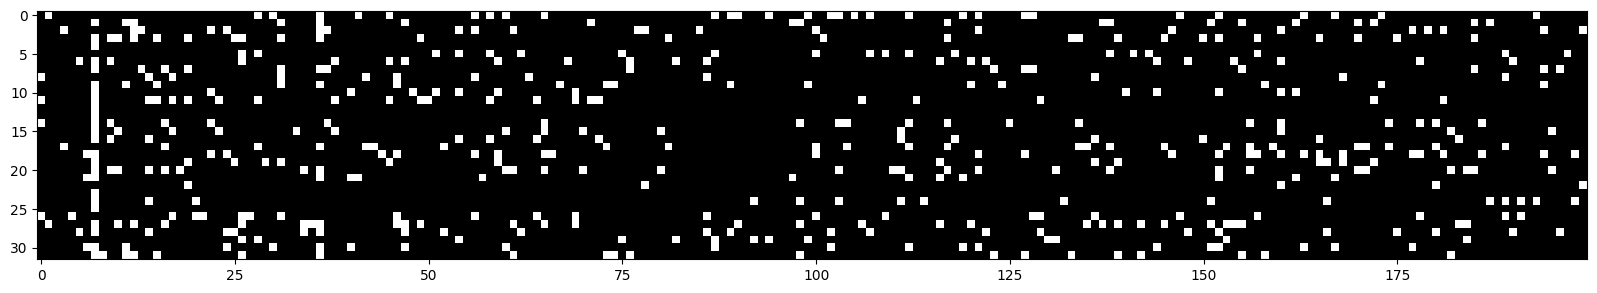

In [9]:
plt.figure(figsize=(20,20))
plt.imshow(h.abs() > 0.99, cmap= 'gray', interpolation='nearest')

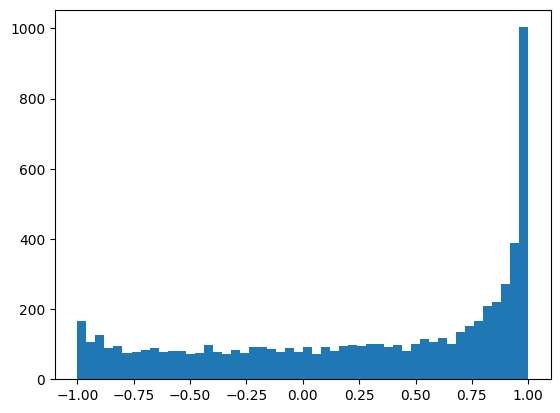

In [54]:
plt.hist(h.view(-1).tolist(), 50);

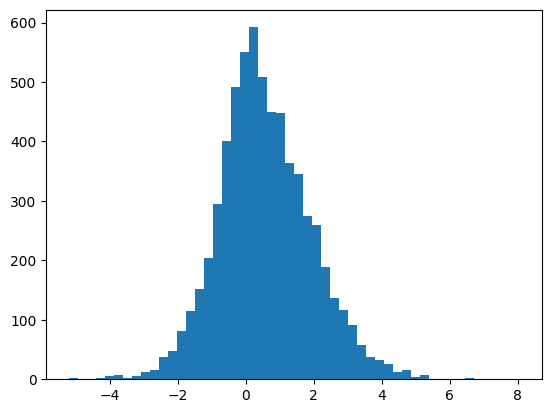

In [55]:
plt.hist(hpreact.view(-1).tolist(), 50);

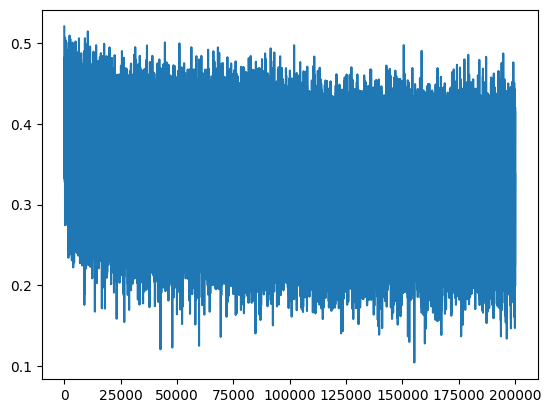

In [56]:
plt.plot(lossi)

In [16]:
@torch.no_grad() # disables gradient tracking doesn't ever
                 # backward pass

def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'eval': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    emb = C[x] 
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    
    hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('eval')

train 2.0669374465942383
eval 2.112175226211548


In [59]:
# sample from the model

g = torch.Generator().manual_seed(125)

for _ in range(20):

    out = []
    context = [0] * block_size

    while True:
        #forward pass the nn
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)

        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()

        # shift the context window and track samples
        context = context[1:] + [ix]
        out.append(ix)

        # is we sample the special token '.', then break the loop
        if ix==0:
            break

    print(''.join(itos[i] for i in out))  

japhthq.
fricqhpzrssaphulfrujphryth.
qilyzanthswne.
xthanfahzten.
buc.
dudmskhuncette.
frwdn.
jonnzhaqlopgegfkton.
jovallyx.
zaddy.
plrshvfrixcadrivzrykx.
guhtdbeastabeulliztravoxdvnalthravordwan.
fowgltyququtomcwesl.
xfigzaqwexlaqwhiltij.
rigweplynn.
thwstgeufraxtobenkynghtrtuw.
frwix.
thoskaqibdh.
qyaqlovellexinndmazzinlgctredgagruxrsxellx.
murwaszoghlanxxxxpapthlixtorfendrexjonkcluwadgn.


# Do everything again. In PyTorch

$$
\frac{x_i - \mu_{\beta}}{\sqrt{\sigma_{\beta}^2} + \epsilon}
$$

In [12]:
# Let's train a deeper network
# The classes we create here are the same API as nn.Module in PyTorch

class Linear:
  
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
    self.bias = torch.zeros(fan_out) if bias else None
  
  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
  
  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      xmean = x.mean(0, keepdim=True) # batch mean
      xvar = x.var(0, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]

class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_embd),            generator=g)
#layers = [
#  Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
#  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
#  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
# Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
#  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
#  Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
#]
layers = [
    Linear(n_embd * block_size, n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), Tanh(),
    Linear(           n_hidden, vocab_size),
]

with torch.no_grad():
  # last layer: make less confident
  layers[-1].weight *= 0.1
  # all other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

46497


In [13]:
# same optimization as last time

max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    # construct minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward
    emb = C[Xb] # embed into vectors
    x = emb.view(emb.shape[0], -1) # concatenate all the vectors together
    for layer in layers: # run through the list of layers and send the data through each layer sequentially
        x = layer(x)
    loss = F.cross_entropy(x, Yb)

    # backward
    for layer in layers:
        layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data = -lr * p.grad

    # track stats
    if i%10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    break

      0/ 200000: 3.2962


layer 1 (      Tanh): mean -0.02, std 0.75, saturated: 20.25%
layer 3 (      Tanh): mean -0.00, std 0.69, saturated: 8.38%
layer 5 (      Tanh): mean +0.00, std 0.67, saturated: 6.62%
layer 7 (      Tanh): mean -0.01, std 0.66, saturated: 5.47%
layer 9 (      Tanh): mean -0.02, std 0.66, saturated: 6.12%


Text(0.5, 1.0, 'activation distribution')

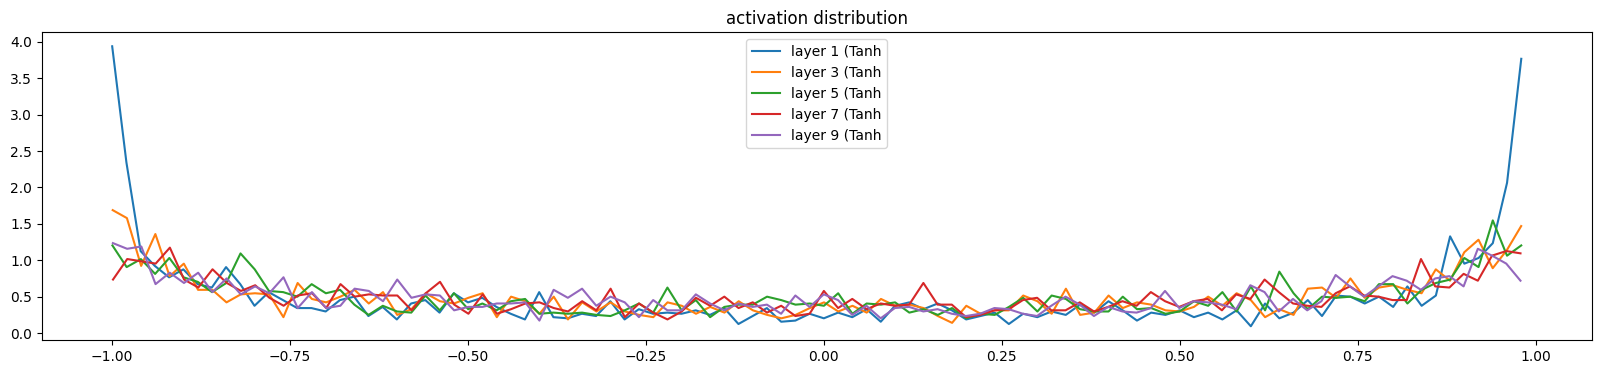

In [14]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 1 (      Tanh): mean +0.000010, std 4.205588e-04
layer 3 (      Tanh): mean -0.000003, std 3.991179e-04
layer 5 (      Tanh): mean +0.000003, std 3.743020e-04
layer 7 (      Tanh): mean +0.000015, std 3.290473e-04
layer 9 (      Tanh): mean -0.000014, std 3.054035e-04


Text(0.5, 1.0, 'gradient distribution')

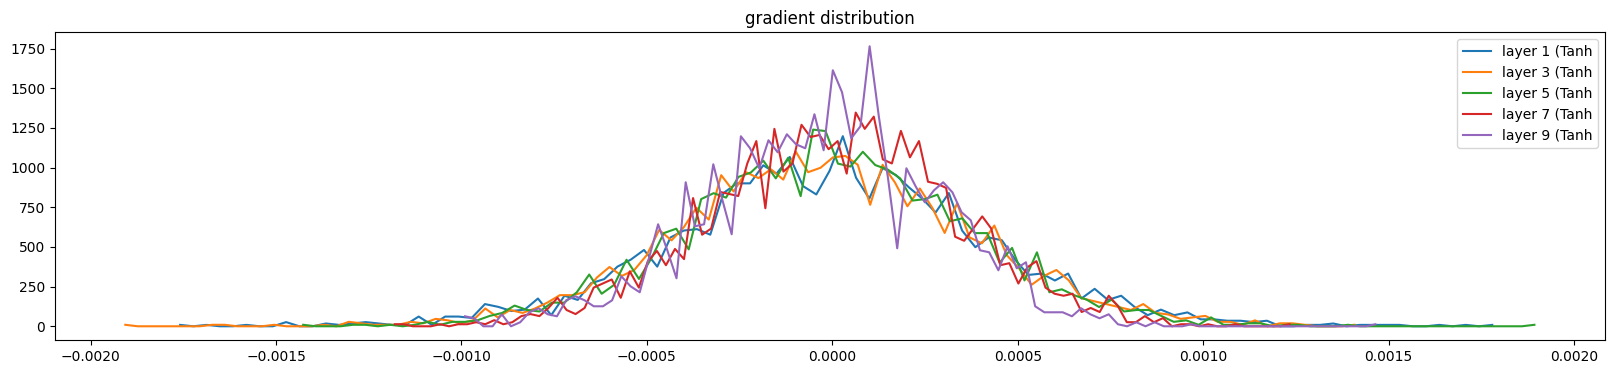

In [15]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')